# Analysis of the LQubitCorrelationSimulator (L=4, J=0)

In this notebook we test the generalised `LQubitCorrelationSimulator` for a four‑qubit chain without Hamiltonian coupling (`J = 0`).  We compare **open** boundary conditions (OBC) with **closed** boundary conditions (CBC) and verify that the dynamics are identical when the coupling constant vanishes.  The simulator evolves the correlation matrix under measurement back‑action and records the magnetisation `⟨σᶻ_i⟩` on each site as well as the entropy production `Q`.

This analysis demonstrates that, in the absence of Hamiltonian interactions, measurement trajectories on different sites remain independent and that periodic boundary conditions have no effect on the statistics.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from l_qubit_correlation_simulator import LQubitCorrelationSimulator


### Trajectory Sanity Check

In [5]:
# Create simulator with strong coupling (J >> 1/tau)
# Set random seed for reproducibility
rng = np.random.default_rng(seed=42)

sim = LQubitCorrelationSimulator(
    L= 4,
    J=10.0,
    epsilon=0.01,
    N_steps=10000,
    T=1.0,
)

print(f"Simulation parameters:")
print(f"  J = {sim.J}")
print(f"  ε = {sim.epsilon}")
print(f"  N = {sim.N_steps}")
print(f"  T = {sim.T}")
print(f"  dt = {sim.dt:.6f}")
print(f"  T/τ = N×ε² = {sim.N_steps * sim.epsilon**2:.3f}")
print(f"  Theoretical ⟨Q⟩ = 3T/τ = {3 * sim.N_steps * sim.epsilon**2:.3f} (if A=0.5)")

Simulation parameters:
  J = 10.0
  ε = 0.01
  N = 10000
  T = 1.0
  dt = 0.000100
  T/τ = N×ε² = 1.000
  Theoretical ⟨Q⟩ = 3T/τ = 3.000 (if A=0.5)


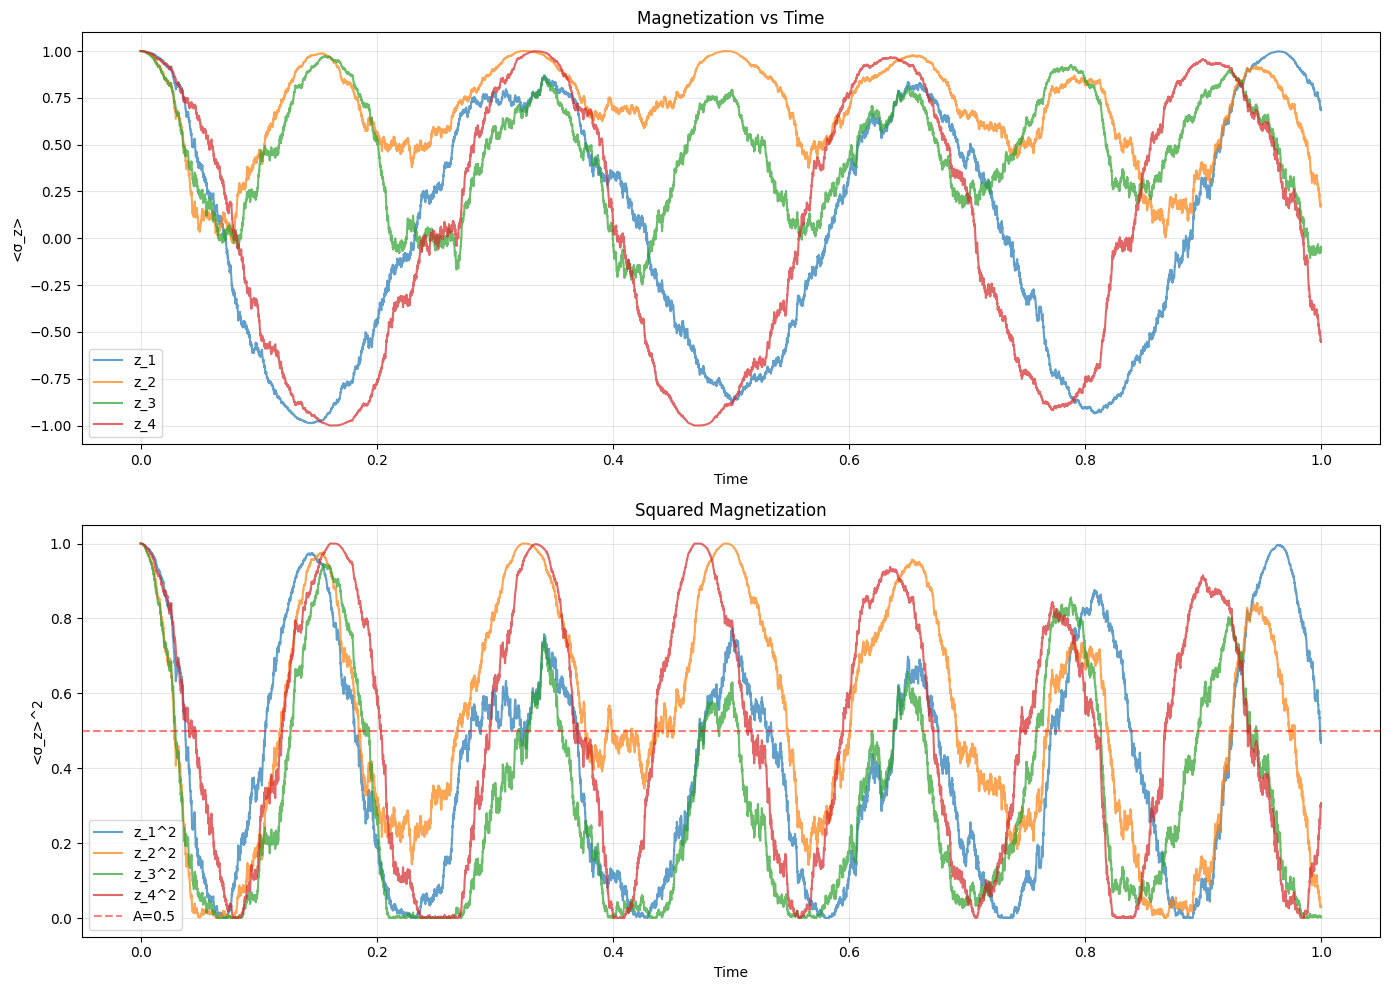

In [7]:
# Simulate single trajectory
Q, z_traj, xi_traj = sim.simulate_trajectory()

# Plot z values over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

times = np.linspace(0, sim.T, sim.N_steps + 1)

# Plot z_i
for i in range(sim.L):
    axes[0].plot(times, z_traj[:, i], label=f'z_{i+1}', alpha=0.7)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('<σ_z>')
axes[0].set_title('Magnetization vs Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot z_i²
for i in range(sim.L):
    axes[1].plot(times, z_traj[:, i]**2, label=f'z_{i+1}^2', alpha=0.7)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='A=0.5', alpha=0.5)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('<σ_z>^2')
axes[1].set_title('Squared Magnetization')
axes[1].legend()
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

### Q Ensamble Analysis
#### L = 3

In [8]:
L = 3
J = 10.0
epsilon = 0.01
N_steps = 10000
T = 1.0
n_traj = 10000
# Simulate open boundary conditions
sim_ensemble = LQubitCorrelationSimulator(L=L, J=J, epsilon=epsilon, N_steps=N_steps,
                                     T=T, closed_boundary=False)
Q, z, xi = sim_ensemble.simulate_ensemble(n_traj, progress=True)

# Calculate statistics
mean_Q = np.mean(Q)
std_Q = np.std(Q)
variance_Q = np.var(Q)
theoretical_Q = sim_ensemble.theoretical_prediction()
# Calculate observed A = ⟨z²⟩
z_squared = z**2  # shape (n_traj, N_steps+1, 2)
A_per_qubit = np.mean(z_squared, axis=(0, 1))  # Average over trajectories and time
A_total = np.mean(z_squared)  # Overall average
mean_z = z.mean(axis=(0, 2))

# Calculate predicted Q using observed A
T_over_tau = sim.N_steps * sim.epsilon**2
predicted_Q_from_A = 2.0 * T_over_tau * (A_total + 1.0)

print(f"\n{'='*60}")
print(f"ENSEMBLE RESULTS (n = {n_traj})")
print(f"{'='*60}")
print(f"\nEntropy Production:")
print(f"  Observed <Q> = {mean_Q:.4f} ± {std_Q:.4f} (variance = {variance_Q:.4f})")
print(f"  Theoretical <Q> (A=0.5) = {theoretical_Q:.4f}")
print(f"  Predicted (observed A) = {predicted_Q_from_A:.4f}")
print(f"  Ratio (obs/theory) = {mean_Q/theoretical_Q:.4f}")
print(f"\nMagnetization Squared:")
for i in range(L):
    print(f"  A_{i+1} = <z_{i+1}²> = {A_per_qubit[i]:.4f}")
print(f"  A_avg = {A_total:.4f}")
print(f"  Expected A = 0.5")
print(f"\nParameters:")
print(f"  T/τ = {T_over_tau:.4f}")
print(f"  J = {sim_ensemble.J}")
print(f"  ε = {sim_ensemble.epsilon}")

Simulating trajectories: 100%|██████████| 10000/10000 [1:45:30<00:00,  1.58it/s]



ENSEMBLE RESULTS (n = 10000)

Entropy Production:
  Observed <Q> = 4.2841 ± 2.2560 (variance = 5.0894)
  Theoretical <Q> (A=0.5) = 4.5000
  Predicted (observed A) = 2.8598
  Ratio (obs/theory) = 0.9520

Magnetization Squared:
  A_1 = <z_1²> = 0.4630
  A_2 = <z_2²> = 0.3637
  A_3 = <z_3²> = 0.4630
  A_avg = 0.4299
  Expected A = 0.5

Parameters:
  T/τ = 1.0000
  J = 10.0
  ε = 0.01


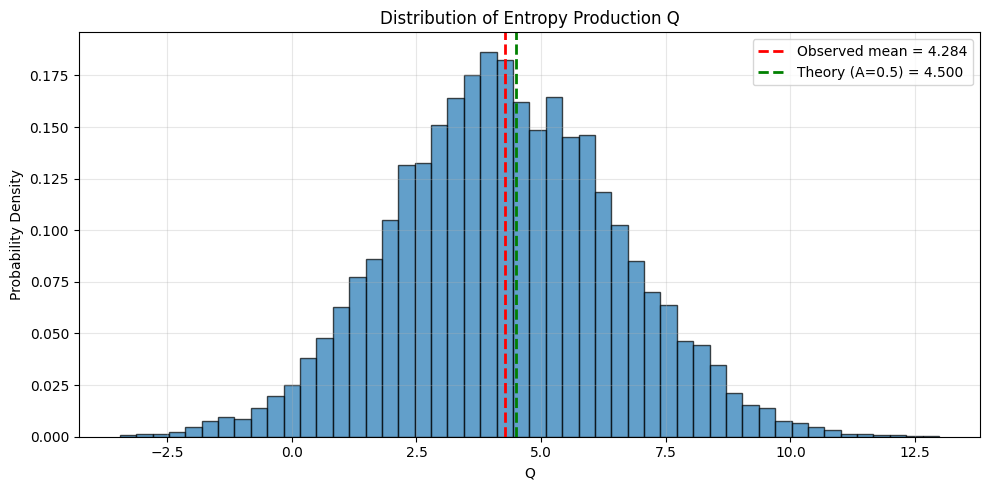

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Histogram of Q
ax.hist(Q, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.axvline(mean_Q, color='r', linestyle='--', linewidth=2, label=f'Observed mean = {mean_Q:.3f}')
ax.axvline(theoretical_Q, color='g', linestyle='--', linewidth=2, label=f'Theory (A=0.5) = {theoretical_Q:.3f}')
ax.set_xlabel('Q')
ax.set_ylabel('Probability Density')
ax.set_title('Distribution of Entropy Production Q')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### L = 2

In [10]:
L = 2
J = 10.0
epsilon = 0.01
N_steps = 10000
T = 1.0
n_traj = 10000
# Simulate open boundary conditions
sim_ensemble = LQubitCorrelationSimulator(L=L, J=J, epsilon=epsilon, N_steps=N_steps,
                                     T=T, closed_boundary=False)
Q, z, xi = sim_ensemble.simulate_ensemble(n_traj, progress=True)

# Calculate statistics
mean_Q = np.mean(Q)
std_Q = np.std(Q)
variance_Q = np.var(Q)
theoretical_Q = sim_ensemble.theoretical_prediction()
# Calculate observed A = ⟨z²⟩
z_squared = z**2  # shape (n_traj, N_steps+1, 2)
A_per_qubit = np.mean(z_squared, axis=(0, 1))  # Average over trajectories and time
A_total = np.mean(z_squared)  # Overall average
mean_z = z.mean(axis=(0, 2))

# Calculate predicted Q using observed A
T_over_tau = sim.N_steps * sim.epsilon**2
predicted_Q_from_A = 2.0 * T_over_tau * (A_total + 1.0)

print(f"\n{'='*60}")
print(f"ENSEMBLE RESULTS (n = {n_traj})")
print(f"{'='*60}")
print(f"\nEntropy Production:")
print(f"  Observed <Q> = {mean_Q:.4f} ± {std_Q:.4f} (variance = {variance_Q:.4f})")
print(f"  Theoretical <Q> (A=0.5) = {theoretical_Q:.4f}")
print(f"  Predicted (observed A) = {predicted_Q_from_A:.4f}")
print(f"  Ratio (obs/theory) = {mean_Q/theoretical_Q:.4f}")
print(f"\nMagnetization Squared:")
for i in range(L):
    print(f"  A_{i+1} = <z_{i+1}²> = {A_per_qubit[i]:.4f}")
print(f"  A_avg = {A_total:.4f}")
print(f"  Expected A = 0.5")
print(f"\nParameters:")
print(f"  T/τ = {T_over_tau:.4f}")
print(f"  J = {sim_ensemble.J}")
print(f"  ε = {sim_ensemble.epsilon}")

Simulating trajectories: 100%|██████████| 10000/10000 [5:03:57<00:00,  1.82s/it]     



ENSEMBLE RESULTS (n = 10000)

Entropy Production:
  Observed <Q> = 2.9968 ± 2.0119 (variance = 4.0478)
  Theoretical <Q> (A=0.5) = 3.0000
  Predicted (observed A) = 3.0097
  Ratio (obs/theory) = 0.9989

Magnetization Squared:
  A_1 = <z_1²> = 0.5049
  A_2 = <z_2²> = 0.5049
  A_avg = 0.5049
  Expected A = 0.5

Parameters:
  T/τ = 1.0000
  J = 10.0
  ε = 0.01


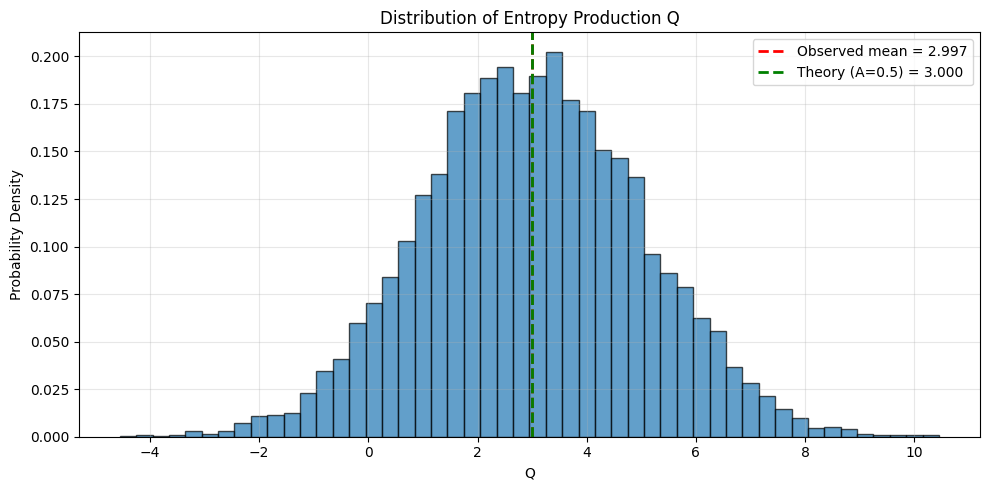

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Histogram of Q
ax.hist(Q, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.axvline(mean_Q, color='r', linestyle='--', linewidth=2, label=f'Observed mean = {mean_Q:.3f}')
ax.axvline(theoretical_Q, color='g', linestyle='--', linewidth=2, label=f'Theory (A=0.5) = {theoretical_Q:.3f}')
ax.set_xlabel('Q')
ax.set_ylabel('Probability Density')
ax.set_title('Distribution of Entropy Production Q')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Compare Open To Close Boundaries

In [ ]:
# Simulate open boundary conditions
sim_obc = LQubitCorrelationSimulator(L=L, J=J, epsilon=epsilon, N_steps=N_steps,
                                     T=T, closed_boundary=False)
Q_obc, z_obc, xi_obc = sim_obc.simulate_ensemble(n_traj, progress=True)

In [ ]:


# Simulate closed boundary conditions
sim_cbc = LQubitCorrelationSimulator(L=L, J=J, epsilon=epsilon, N_steps=N_steps,
                                     T=T, closed_boundary=True)
Q_cbc, z_cbc, xi_cbc = sim_cbc.simulate_ensemble(n_traj, progress=True)

# Compute mean magnetisation over trajectories and sites at each time step
mean_z_obc = z_obc.mean(axis=(0, 2))
mean_z_cbc = z_cbc.mean(axis=(0, 2))

# Compute difference between OBC and CBC magnetisations
mag_diff = mean_z_obc - mean_z_cbc

print("Average entropy production (OBC):", Q_obc.mean())
print("Average entropy production (CBC):", Q_cbc.mean())


TypeError: LQubitCorrelationSimulator.__init__() got an unexpected keyword argument 'progress'

In [ ]:
plt.figure(figsize=(6, 4))
time = np.linspace(0, T, N_steps + 1)
plt.plot(time, mean_z_obc, label='OBC')
plt.plot(time, mean_z_cbc, '--', label='CBC', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Mean magnetisation')
plt.title('Mean magnetisation ⟨σᶻ⟩ vs time (J=0)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Plot Q histogram
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

times = np.linspace(0, sim_obc.T, sim_obc.N_steps + 1)

# Plot open boundary condition Q
axes[0].hist(Q_obc, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].axvline(Q_obc.mean, color='r', linestyle='--', linewidth=2, label=f'Observed mean = {Q_obc.mean:.3f}')
axes[0].set_xlabel('Q')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Distribution of Entropy Production Q for OBC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Plot closed boundary condition Q
axes[1].hist(Q_cbc, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1].axvline(Q_cbc.mean, color='r', linestyle='--', linewidth=2, label=f'Observed mean = {Q_cbc.mean:.3f}')
axes[1].set_xlabel('Q')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Distribution of Entropy Production Q for CBC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [ ]:
# Extract final magnetisation of site 0 for each trajectory
final_z_obc = z_obc[:, -1, 0]
final_z_cbc = z_cbc[:, -1, 0]

plt.figure(figsize=(6, 4))
plt.hist(final_z_obc, bins=np.linspace(-1, 1, 21), alpha=0.5, label='OBC')
plt.hist(final_z_cbc, bins=np.linspace(-1, 1, 21), alpha=0.5, label='CBC')
plt.xlabel('Final magnetisation of site 0')
plt.ylabel('Count')
plt.title('Distribution of final magnetisation (site 0)')
plt.legend()
plt.grid(True)
plt.show()

# Plot difference between OBC and CBC mean magnetisation
plt.figure(figsize=(6, 4))
plt.plot(time, mag_diff)
plt.xlabel('Time')
plt.ylabel('Δ mean magnetisation (OBC - CBC)')
plt.title('Difference between OBC and CBC mean magnetisation')
plt.grid(True)
plt.show()

# Display maximum absolute difference
max_diff = np.abs(mag_diff).max()
print(f"Maximum absolute difference in mean magnetisation: {max_diff:.3e}")


## Discussion

The plots above compare the mean magnetisation for open and closed boundary conditions when `J = 0`.  Because there is no Hamiltonian coupling, each qubit evolves independently under measurement, so the boundary choice has no effect.  This is evidenced by the overlapping magnetisation curves and the negligible difference (of order 10⁻¹⁵) between them.

The histograms of the final magnetisation on site 0 show identical distributions for OBC and CBC.  On average the entropy production `Q` is the same for both ensembles.  These observations confirm the expectation that **for `J = 0` all trajectories are independent**, and periodic coupling plays no role.  When `J ≠ 0` the magnetisation dynamics and entropy production would differ between OBC and CBC due to the boundary interaction.
